# Logistic Regression and Softmax: The Classification Problem

## Binary Classification

A common challenge is: given some data about an object and some groups the object can belong to, predict which group this object will belong to. For example, given health information (age, height, weight, etc.), predict whether this person has heart disease/cancer/etc. We'll tackle problems like this, but we have to start simple. We will work on the *binary classification problem*, that is, given two groups, predict which of these two this object belongs to.

We will try to predict whether flowers from the Iris species are Setosa or Versicolor based on their sepal width and length.

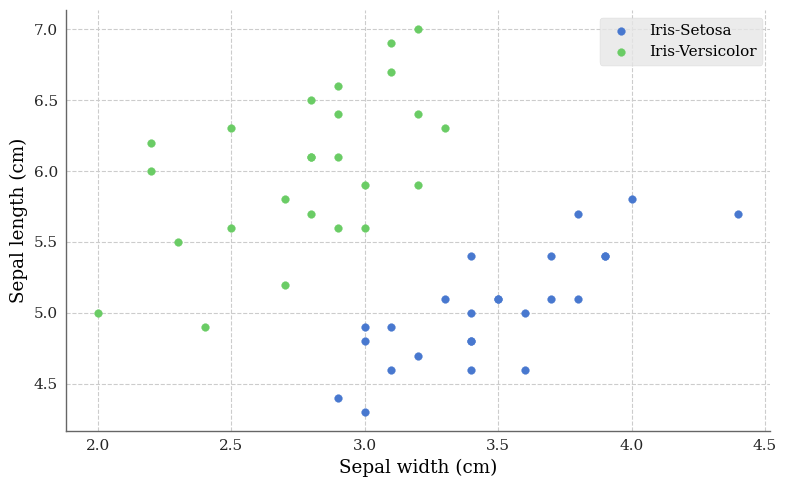

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv("./data/iris.csv")

setosa_width_train = np.array(data["SepalWidthCm"])[:25]
setosa_length_train = np.array(data["SepalLengthCm"])[:25]
setosa_width_test = np.array(data["SepalWidthCm"])[25:50]
setosa_length_test = np.array(data["SepalLengthCm"])[25:50]

versi_width_train = np.array(data["SepalWidthCm"])[50:75]
versi_length_train = np.array(data["SepalLengthCm"])[50:75]
versi_width_test = np.array(data["SepalWidthCm"])[75:100]
versi_length_test = np.array(data["SepalLengthCm"])[75:100]

config = {
'axes.spines.right': False,
'axes.spines.top': False,
'axes.edgecolor': '.4',
'axes.labelcolor': '.0',
'axes.titlesize': 'large',
'axes.labelsize': 'large',
'figure.autolayout': True,
'figure.figsize': (8, 5),
'font.family': ['serif'],
'font.size': 11.0,
'grid.linestyle': '--',
'legend.facecolor': '.9',
'legend.frameon': True,
'legend.fontsize': 'medium',
'savefig.transparent': True,
'text.color': '.0',
'xtick.labelsize': 'medium',
'ytick.labelsize': 'medium',
}

plt.style.use(['seaborn-v0_8-whitegrid', 'seaborn-v0_8-paper', 'seaborn-v0_8-muted', config])

fig, ax = plt.subplots()
ax.set_xlabel("Sepal width (cm)")
ax.set_ylabel("Sepal length (cm)")

ax.scatter(setosa_width_train, setosa_length_train, label="Iris-Setosa")
ax.scatter(versi_width_train, versi_length_train, label="Iris-Versicolor")
ax.legend()

We could try to use linear regression on this problem. However, recall that our model is $\boldsymbol y = \boldsymbol w^\top \boldsymbol x$, which results in real numbers, not classifications. We can fix this, by taking the sign of our output with the sign function:
$$
\operatorname{sgn}(x) =
\begin{cases}
-1, & x < 0 \\
1, & x \ge 0
\end{cases}
$$
And then we can associate, say, 1 to Setosa and -1 to Versicolor. Unfortunately, this function is not differentiable, so we can't use it during the optimization step. But maybe we could do the optimization step without it, and then only use it in our final model, that being $\hat y = \operatorname{sgn}(\boldsymbol w^\top \boldsymbol x$. Weellll....

That is possible, but it results in a pretty bad model (TODO: add example?). So what else can we try?

### The Sigmoid

Likely, what causes the problem is that we would use $\hat y = \boldsymbol w^\top \boldsymbol x$ in the optimization step while using $\hat y = \operatorname{sgn}(\boldsymbol w^\top \boldsymbol x$ after the optimization - two different functions. So it is probably better if both are the same. For that, though, we'd still need to wrap $\boldsymbol w^\top \boldsymbol x$ around a function, and to be able to use it in the optimization, we would need it to be differentiable. What function is a good candidate for this? A nifty little thing called the *sigmoid!*
$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$
This little guy is our best friend now! Here is its graph:

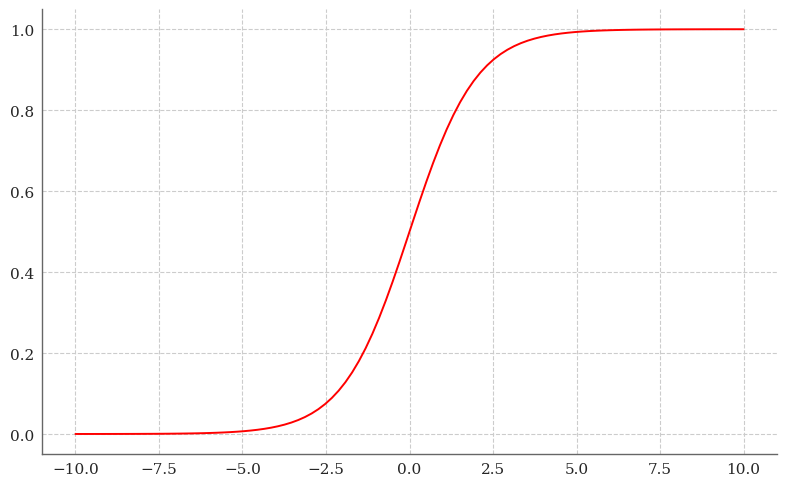

In [2]:
sigmoid = lambda x : (1 / (1 + np.exp(-x)))
fig, ax = plt.subplots()

X = np.linspace(-10, 10, num=100)
Y = sigmoid(X)
ax.plot(X, Y, color='red')

Notice that it outputs *real* values between 0 and 1. So we aren't really getting our binary 0's and 1's as we wanted. But adding this degree of freedom is fine. We can interpret it as a probability, since something more continuous will play better with gradient descent. If we wish, we can still collapse the output into either 0 or 1 later: just pick which number is closer. So the sigmoid is a fine candidate here. It also has a nice derivative, which will help:
$$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$

So our model now will be $\hat y = \sigma(\boldsymbol w^\top \boldsymbol x)$. This also demands a different cost function, since the shape of our outputs (*and* of the training data) has changed significantly.

### Cross entropy loss

For a particular pair $(\boldsymbol x_i, y_i)$ in our data set, the loss function will be the *cross entropy loss:*
$$L = -\Bigl(y_i\log\bigl(\sigma(\boldsymbol w^\top \boldsymbol x)\bigr) + (1 - y_i)\log\bigl(1 - \sigma(\boldsymbol w^\top \boldsymbol x)\bigr)\Bigr)$$
...I won't be trying to explain why the heck this is the case. We'll just accept that this works for funky statistics reasons. Then our cost function will be:
$$
\mathcal J(\boldsymbol w)
= -\frac 1N \sum_{i=1}^N \Bigl(y_i\log\bigl(\sigma(\boldsymbol w^\top \boldsymbol x_i)\bigr) + (1 - y_i)\log\bigl(1 - \sigma(\boldsymbol w^\top \boldsymbol x_i)\bigr)\Bigr)$$
One good thing about this is that it has a nice gradient:
$$
\nabla_{\boldsymbol w} \mathcal J(\boldsymbol w) 
= - \frac 1N \sum_{i=1}^N (y_i - \sigma(\boldsymbol w^\top \boldsymbol x_i))\boldsymbol x_i 
= - \frac 1N\sum_{i=1}^N (y_i - \hat y_i)\boldsymbol x_i = -\frac 1N \boldsymbol X^\top(\boldsymbol y - \hat{\boldsymbol y})$$
And now that we have that, we are actually all set to implement gradient descent!

Starting cost: 1.7536961295576459
Final cost: 0.28745608248932647
Weights:
 [[ 0.7257224 ]
 [ 1.76845487]
 [-1.14701019]]
Accuracy on tests: 98.0%


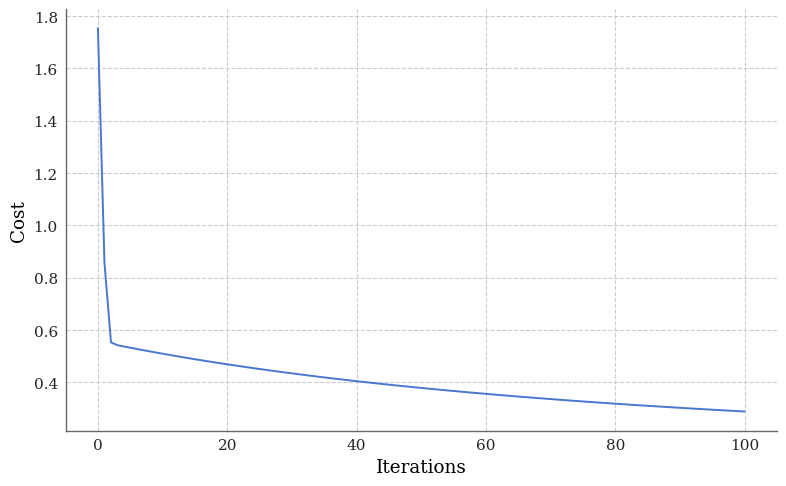

In [3]:
def logistic_cost(X, y, w):
    N, _ = X.shape
    
    yhat = sigmoid(np.matmul(X, w))
    
    return - 1/N * np.sum(y * np.log(yhat) + (1-y) * np.log(1 - yhat))

def logistic_gradient(X, y, w):
    N, _ = X.shape

    yhat = sigmoid(np.matmul(X, w))

    return -1/N * np.matmul(X.transpose(), y - yhat)

def logistic_regressionGD(x_data, y_data, alpha=1, n=25):
    """Applies `n` iterations of logistic gradient descent."""
    
    N, D = x_data.shape

    X = np.concatenate((np.ones((N, 1)), x_data), axis=1)
    y = y_data

    w = np.random.rand(D+1, 1)
    print("Starting cost:", logistic_cost(X, y, w))
    costs = []    
    for _ in range(n):
        costs.append(logistic_cost(X, y, w))
        w = w - alpha * logistic_gradient(X, y, w)
    print("Final cost:", logistic_cost(X, y, w))
    return w, costs

N = 25
# make sure data has the right shape
setosa_width = setosa_width_train.reshape(N, 1)
setosa_length = setosa_length_train.reshape(N, 1)
versi_width = versi_width_train.reshape(N, 1)
versi_length = versi_length_train.reshape(N, 1)

# collect all the inputs together
setosa_data = np.concatenate((setosa_width, setosa_length), axis=1)
versi_data = np.concatenate((versi_width, versi_length), axis=1)
x_data = np.concatenate((setosa_data, versi_data), axis = 0)

# get our outputs: 1 is setosa, 0 is versicolor
y_data = np.concatenate((np.array([1] * N), np.array([0] * N))).reshape(2*N, 1)

w, costs = logistic_regressionGD(x_data, y_data, alpha=0.1, n=100)
print("Weights:\n", w)

model = lambda x : sigmoid(np.dot(x, w))
correct = 0
for i in range(N):
    if model(np.array(([1, setosa_width_test[i], setosa_length_test[i]]))) >= 0.5:
        correct +=1
    if model(np.array([1, versi_width_test[i], versi_length_test[i]])) <= 0.5:
        correct +=1

print(f"Accuracy on tests: {100*correct/(2*N)}%")

fig, ax = plt.subplots()
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.plot(np.linspace(0, 100, num=100), costs)

# TODO: add regions plot

Looking good, we have amazing accuracy on the test data! But... oh no! What is this, another flower is coming in?

## Multiclass Regression

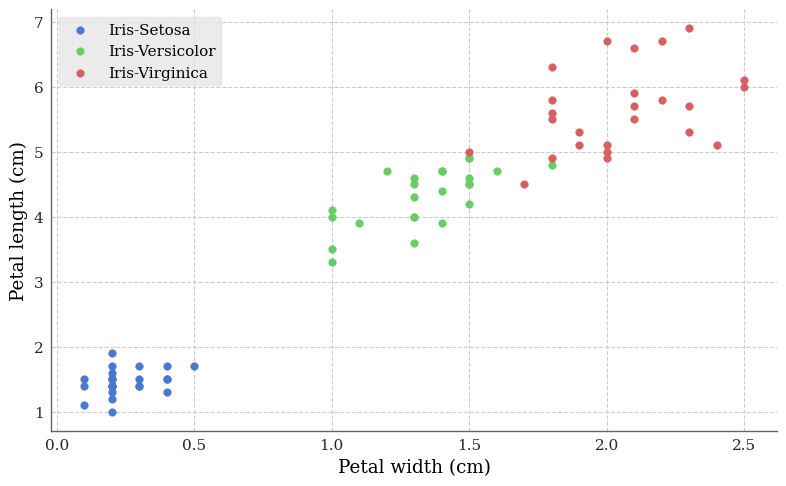

In [2]:
setosa_width_train = np.array(data["PetalWidthCm"])[:25]
setosa_length_train = np.array(data["PetalLengthCm"])[:25]
setosa_width_test = np.array(data["PetalWidthCm"])[25:50]
setosa_length_test = np.array(data["PetalLengthCm"])[25:50]

versi_width_train = np.array(data["PetalWidthCm"])[50:75]
versi_length_train = np.array(data["PetalLengthCm"])[50:75]
versi_width_test = np.array(data["PetalWidthCm"])[75:100]
versi_length_test = np.array(data["PetalLengthCm"])[75:100]

virgi_width_train = np.array(data["PetalWidthCm"])[100:125]
virgi_length_train = np.array(data["PetalLengthCm"])[100:125]
virgi_width_test = np.array(data["PetalWidthCm"])[125:150]
virgi_length_test = np.array(data["PetalLengthCm"])[125:150]

fig, ax = plt.subplots()
ax.set_xlabel("Petal width (cm)")
ax.set_ylabel("Petal length (cm)")

ax.scatter(setosa_width_train, setosa_length_train, label="Iris-Setosa")
ax.scatter(versi_width_train, versi_length_train, label="Iris-Versicolor")
ax.scatter(virgi_width_train, virgi_length_train, label="Iris-Virginica")

ax.legend()

Damn it! Now it looks we have to sort between Setosa, Versicolor, *and* Virginica. Okay, we know how to do this with two things - it can't be that hard to do it with three, now can it?

As it turns out, like a lot of other things in mathematics, two is easy, but three is as difficult as the general case. So we might as well go and study the general case: suppose we have $K$ possible classifications. The first issue is how to represent this output. It'll be really hard for a single number to really say much here, so we should probably give in and finally allow our outputs to be vectors as well. But what kinds of vectors?

One idea is a $K\times 1$ vector that represents how "confident" the model is regarding each possibility. Something like $\hat{\boldsymbol y} = [0.05\; 0.1\; 0.9]^\top$ could mean that the vector is pretty confident that it's a Virginica, and little confident that it'd be either Setosa or Versicolor. After that, we can pick our classification by seeing which of the components is bigger (i.e. the most "confident" guess). This is called the *linear discriminant* of the output, and one of the reasons that it's good is because it'll separate the plane into convex reasons, which makes sense: if I have two outputs which are Setosa, any output that is between these two (i.e. is a "mixture" between them) should probably be Setosa as well.

We will need some new notation. Now $\boldsymbol y$ represents a single output, and is a $K\times 1$ vector. $\boldsymbol x$ is still an input, a $(D+1)\times 1$ vector. Our dataset will be pairs $(\boldsymbol x, \boldsymbol y)$ of patterns and outputs. $\boldsymbol x_i$ and $\boldsymbol y_i$ are then the $i$-th input and output. Like before, we put all the patterns into a $N\times (D+1)$ matrix $\boldsymbol X$. But now, we also have a $N\times K$ matrix:
$$\boldsymbol Y =
\begin{pmatrix}
y_{11} & y_{12} & \cdots & y_{1K} \\
y_{21} & y_{22} & \cdots & y_{2K} \\
\vdots & \vdots & \ddots & \vdots \\
y_{N1} & y_{N2} & \cdots & y_{NK} 
\end{pmatrix} =
\begin{pmatrix}
\boldsymbol y_1^\top \\
\boldsymbol y_2^\top \\
\vdots \\
\boldsymbol y_N^\top \\
\end{pmatrix}$$

### Linear multivariate regression

Now what happens to the weights? Well, if we think back to linear model, each component of the output could be some linear combination of the components of the input. In other words, our model on the input $\boldsymbol x_i$, our model should be a $\hat{\boldsymbol y}_i$ whose $k$-th component would is
$$\hat y_{ik} = w_{k0} + w_{k1}x_{i1} + \cdots + w_{kD} x_{iD} =
\begin{pmatrix}
w_{k0} & w_{k1} & \cdots & w_{kD}
\end{pmatrix}
\begin{pmatrix}
1\\
x_{i1} \\
x_{i2} \\
x_{iD} \\
\end{pmatrix}
= \boldsymbol w_k^\top \boldsymbol x_i
$$
So there is a vector of weights $\boldsymbol w_j$ associated with each class. We can then get the $(D+1)\times K$ matrix:
$$ \boldsymbol W =
\begin{pmatrix}
w_{01} & w_{01} & \cdots & w_{0K} \\
w_{11} & w_{12} & \cdots & w_{1K} \\
\vdots & \vdots & \ddots & \vdots \\
w_{D1} & w_{D2} & \cdots & w_{DK} 
\end{pmatrix} =
\begin{pmatrix}
\boldsymbol w_0 & \boldsymbol w_1 & \cdots & \boldsymbol w_K
\end{pmatrix}
$$
Finally, we can sum all this up as:
$$
\begin{align*}
&\hat{\boldsymbol y}_i = \boldsymbol W^\top \boldsymbol x_i\text{, whence}\\
&\hat{\boldsymbol Y} =  \boldsymbol X \boldsymbol W
\end{align*}$$

Where $\hat{\boldsymbol Y}$ is a matrix whose rows are the $y_i^\top$.

We still need a cost function, though. But we don't have to think too hard about it: it'll really just be a copy of MSE. Before, we used the L2 norm $||\cdot||$ for vectors. Now, we'll use the Frobenius norm $||\cdot||_F$ for matrices - which is really just an L2 norm but in a matrix instead, as you'll see:
$$
\mathcal J(\boldsymbol W) = \frac 1N \sum_{i=1}^N ||\boldsymbol Y - \hat{\boldsymbol Y}||^2_F
= \frac 1N \sum_{i=1}^N ||\boldsymbol y_i - \hat{\boldsymbol y}_i||^2 = \frac 1N\sum_{i=1}^N\sum_{k=1}^K |y_{ik} - \hat y_{ik}|^2
$$

I'll skip finding the gradient of this and just be upfront: like before, there's also an analytic solution. You can probably even guess what it is.
$$
\boldsymbol W = \boldsymbol(\boldsymbol X^\top \boldsymbol X)^{-1}\boldsymbol X^\top \boldsymbol Y 
$$
And I'll else break the bad news: this isn't very good for solving classification tasks. So, like before, we need to give a little boost to our linear solution with some non-linearity. Where is this non-linearity going to come from, you say? Glad you asked!

### Softmax
Our model, actually, will be defined by the following baby:
$$\hat y_{ik} = \frac{\exp(\boldsymbol w_k^\top\boldsymbol x_i)}{\sum_{j=1}^K \exp(\boldsymbol w_j^\top \boldsymbol x_i)}$$
which is called the *softmax*. It is much like the sigmoid, and should be thought of as a probability: notice how all the components of a single $\hat{\boldsymbol y}_i$ will add up to 1. While it *is* scary, it is also familiar, right? Same will go for the cost function, called *multiclass cross-entropy*:
$$
\mathcal J(\boldsymbol W) = - \frac 1N \sum_{i=1}^N \sum_{k=1}^K y_{ik}\log(\hat y_{ik})
$$
Similarly, the gradient is quite familiar. We will have, for each $\boldsymbol w_k$, that:
$$
\frac{\partial \mathcal J}{\partial \boldsymbol w_k}
= -\frac 1N \sum_{i=1}^N [y_{ik} - \hat y_{ik}]\boldsymbol x_i
$$
Which gives us back the familiar formula:
$$
\nabla_{\boldsymbol W} \mathcal J(\boldsymbol W) = - \frac 1N \boldsymbol X^\top (\boldsymbol Y - \hat{\boldsymbol Y})
$$

So finally! We can solve the classification problem for many classes. Yay.

In [5]:
def softmax_cost(X, Y, W):
    N, _ = X.shape
    Yhat = np.exp(np.matmul(X, W))
    for i in range(len(Yhat)):
        Yhat[i] = Yhat[i]/np.sum(Yhat[i])
        
    return -1/N * np.sum(Y * np.log(Yhat))

def softmax_gradient(X, Y, W):
    N, _ = X.shape
    Yhat = np.exp(np.matmul(X, W))
    for i in range(len(Yhat)):
        Yhat[i] = Yhat[i]/np.sum(Yhat[i])

    return - 1/N * np.matmul(X.T, Y - Yhat) 

def softmax_regressionGD(x_data, y_data, alpha=1, n=100):
    """Applies `n` iterations of softmax gradient descent.
    `x_data` should be $N\times D$, where $D$ is the number of
    features and $N$ is the number of patterns.
    `y_data` should be $N\times K$, where $K$ is the number of
    classes.
    `alpha` is the learning rate."""
    N, D = x_data.shape
    _, K = y_data.shape

    X = np.concatenate((np.ones((N, 1)), x_data), axis=1)
    Y = y_data

    W = np.random.rand(D+1, K)

    print("Starting Cost:", softmax_cost(X, Y, W))
    
    for _ in range(n):
        W -= alpha * softmax_gradient(X, Y, W)

    print("End Cost:", softmax_cost(X, Y, W))
    return W

def softmax_model(x, W):
    yhat = np.matmul(W.T, x)
    return yhat / np.sum(yhat)

N = 25
setosa_width = setosa_width_train.reshape(N, 1)
setosa_length = setosa_length_train.reshape(N, 1)
versi_width = versi_width_train.reshape(N, 1)
versi_length = versi_length_train.reshape(N, 1)
virgi_width = virgi_width_train.reshape(N, 1)
virgi_length = virgi_length_train.reshape(N, 1)

setosa_data = np.concatenate((setosa_width, setosa_length), axis=1)
versi_data = np.concatenate((versi_width, versi_length), axis=1)
virgi_data = np.concatenate((virgi_width, virgi_length), axis=1)

x_data = np.concatenate((setosa_data, versi_data, virgi_data), axis=0)

y_data = np.concatenate((
    np.array([1, 0, 0] * N).reshape(N, 3),
    np.array([0, 1, 0] * N).reshape(N, 3),
    np.array([0, 0, 1] * N).reshape(N, 3)
    ), axis=0
)

W = softmax_regressionGD(x_data, y_data, alpha=0.2, n=1000)
print("Weight matrix:\n", W)

correct = 0
for i in range(N):
    setosa_result = softmax_model(np.array(([1, setosa_width_test[i], setosa_length_test[i]])), W)
    versi_result  = softmax_model(np.array(([1, versi_width_test[i], versi_length_test[i]])), W)
    virgi_result  = softmax_model(np.array(([1, virgi_width_test[i], virgi_length_test[i]])), W)
    
    if max(setosa_result) == setosa_result[0]:
        correct += 1
    if max(versi_result) == versi_result[1]:
        correct += 1
    if max(virgi_result) == virgi_result[2]:
        correct += 1

print(f"Test data accuracy: {100*correct/(3*N)}%")

Starting Cost: 1.1884476265152555
End Cost: 0.2256274119628905
Weight matrix:
 [[ 6.55140968  0.6721701  -5.457254  ]
 [-1.80753852 -0.54678871  3.91690001]
 [-0.32358965  1.57055372  1.32565695]]
Test data accuracy: 94.66666666666667%


Once again, a success! It is also worth mentioning that, if we had bigger datasets, we could also have implemented stochastic gradient descent instead to mitigate that.